In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# ---------- 1) Load ----------
portfolios5x5 = pd.read_csv('25_Portfolios_5x5_Daily.csv')
reversalFactor = pd.read_csv('F-F_LT_Reversal_Factor_daily.csv')
momentumFactor = pd.read_csv('F-F_Momentum_Factor_daily.csv')
researchData   = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')

for df in [portfolios5x5, reversalFactor, momentumFactor, researchData]:
    df.dropna(inplace=True)
    # divide all return columns (except the date col) by 100
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors='coerce')/100.0
#print(portfolios5x5.head(), portfolios5x5.tail(), reversalFactor.head(), reversalFactor.tail(), momentumFactor.head(), researchData.head(), researchData.tail() )
# ---------- 2) Merge on date ----------
df = portfolios5x5.merge(reversalFactor, on='Unnamed: 0') \
                  .merge(momentumFactor, on='Unnamed: 0') \
                  .merge(researchData,   on='Unnamed: 0')

# ---------- 3) Basic cleaning ----------
df = df.rename(columns={'Unnamed: 0':'Date'})
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

# keep 2008+
df = df[df['Date'] >= '2008-01-01'].copy()

for c in df.columns:
    if c != 'Date':
        df = df[df[c].abs() < 1]

#print(df.head(), df.tail())
df = df.set_index('Date').sort_index()

# ---------- 4) Daily → Monthly (compounded) ----------
def compound_month(x):
    return (1.0 + x).prod() - 1.0

monthly = df.resample('M').apply(compound_month).dropna()
#display(monthly)
# ---------- 5) OLS for one portfolio ----------
port_col = 'SMALL HiBM'  # pick any of the 25 columns you want
monthly['ExcessRet'] = monthly[port_col] - monthly['RF']

X = monthly[['Mkt-RF','SMB','HML','RMW','CMA','Mom']]
X = sm.add_constant(X)                # intercept = alpha
y = monthly['ExcessRet']

ols = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':3})
print(ols.summary())
print('Monthly alpha (const):', float(ols.params['const']))


C:\Users\creat\AppData\Local\Temp\ipykernel_18636\1365246018.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  portfolios5x5 = pd.read_csv('25_Portfolios_5x5_Daily.csv')
C:\Users\creat\AppData\Local\Temp\ipykernel_18636\1365246018.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').apply(compound_month).dropna()


                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     177.9
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           5.44e-78
Time:                        06:35:02   Log-Likelihood:                 312.07
No. Observations:                 210   AIC:                            -610.1
Df Residuals:                     203   BIC:                            -586.7
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0172      0.004      4.002      0.0

In [ ]:
import pymc as pm
import xarray as xr
import arviz as az


def prep_Xy(X, y, eps=1e-8):
    # ensure arrays
    X = np.asarray(X, float)
    y = np.asarray(y, float)

    # drop rows with any non-finite values
    mask = np.isfinite(X).all(1) & np.isfinite(y)
    X, y = X[mask], y[mask]

    # de-mean and standardize with eps (avoid divide-by-zero)
    X_mean = X.mean(0)
    X_std  = X.std(0, ddof=1)
    X_std[X_std < eps] = 1.0  # protect constant cols

    y_mean = y.mean()
    y_std  = y.std(ddof=1)
    if y_std < eps:  # protect near-constant target
        y_std = 1.0

    Xz = (X - X_mean) / X_std
    yz = (y - y_mean) / y_std

    # clip extreme z-scores (helps VI)
    Xz = np.clip(Xz, -8.0, 8.0)
    yz = np.clip(yz, -8.0, 8.0)

    return Xz, yz, (X_mean, X_std, y_mean, y_std)

Xz, yz, scales = prep_Xy(X, y)  # your X (factors), y (EXCESS returns)
n, p = Xz.shape
X_mean, X_std, y_mean, y_std = scales

with pm.Model() as hs_model:
    # Intercept in standardized space
    alpha = pm.Normal("alpha", mu=0.0, sigma=5.0)

    # STABLE shrinkage (HalfNormal instead of HalfCauchy)
    tau = pm.HalfNormal("tau", sigma=1.0)                # global
    lam = pm.HalfNormal("lambda", sigma=1.0, shape=p)    # local

    beta = pm.Normal("beta", mu=0.0, sigma=tau * lam, shape=p)

    # Observation noise (std) — HalfNormal is VI-friendly
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    mu = alpha + pm.math.dot(Xz, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=yz)

    # ADVI with convergence check
    advi = pm.fit(
        30000,
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)]
    )
    trace = advi.sample(2000)

post = trace.posterior
alpha_z = float(post["alpha"].mean(("chain","draw")))
beta_z  = post["beta"].mean(("chain","draw")).values
lam_m   = post["lambda"].mean(("chain","draw")).values

# Inclusion-like importance (smaller lam => less shrinkage)
importance = 1.0 / (1.0 + lam_m**2)

# Unstandardize back to original units
beta_unstd  = beta_z * (y_std / X_std)
alpha_unstd = y_mean + y_std * (alpha_z - (X_mean / X_std) @ beta_z)

print("alpha (original units):", alpha_unstd)
print("beta  (original units):", beta_unstd)
print("importance (0≈excluded, 1≈kept):", importance)


Output()

Finished [100%]: Average Loss = 127.61


alpha (original units): 0.022635713386688853
beta  (original units): [-0.00572421  0.82425322  1.06690441  0.07649407 -0.24649025  0.60188616
 -0.22497292]
importance (0≈excluded, 1≈kept): [0.50033769 0.48650339 0.53586674 0.82712889 0.7580282  0.69887708
 0.71176812]


In [ ]:
with hs_model:
    idata_hs = pm.sample(
        draws=500, tune=500, target_accept=0.9,
        idata_kwargs={"log_likelihood": True},
        chains=4, cores=4
    )

waic_val = az.waic(idata_hs)
print(waic_val)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, lambda, beta, sigma]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 355 seconds.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Computed from 2000 posterior samples and 210 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -121.01    60.53
p_waic       29.98        -

There has been a warning during the calculation. Please check the results.


c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


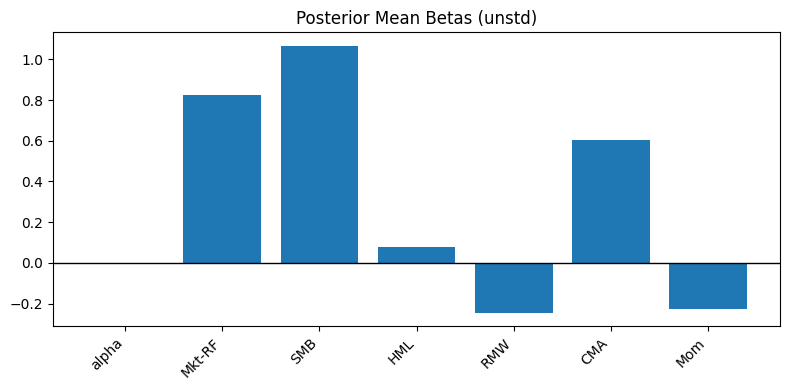

In [58]:
factor_names = ["alpha"] + list(X.columns[1:])
fig_beta, ax_beta = plt.subplots(figsize=(8,4))
ax_beta.bar(range(len(beta_unstd)), beta_unstd)
ax_beta.axhline(0, lw=1, color='k')
ax_beta.set_xticks(range(len(beta_unstd)))
ax_beta.set_xticklabels(factor_names, rotation=45, ha='right')
ax_beta.set_title("Posterior Mean Betas (unstd)")
plt.tight_layout()
plt.show()


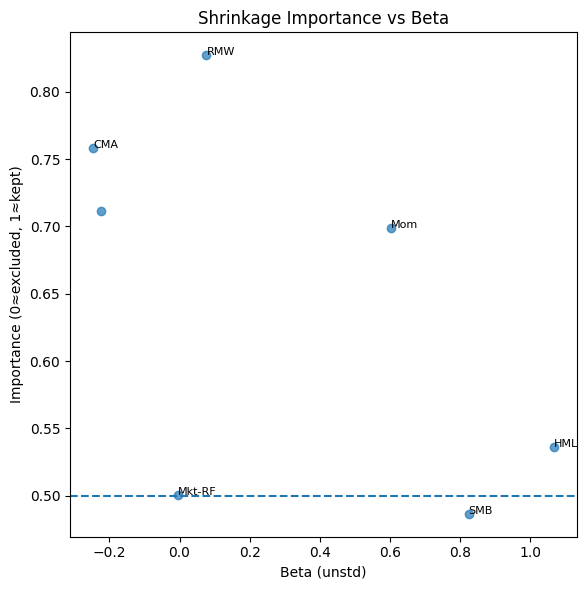

In [59]:
fig_imp, ax_imp = plt.subplots(figsize=(6,6))
ax_imp.scatter(beta_unstd, importance, alpha=0.7)
for i, lbl in enumerate(X.columns[1:]):
    ax_imp.text(beta_unstd[i], importance[i], lbl, fontsize=8)
ax_imp.axhline(0.5, ls="--")
ax_imp.set_xlabel("Beta (unstd)")
ax_imp.set_ylabel("Importance (0≈excluded, 1≈kept)")
ax_imp.set_title("Shrinkage Importance vs Beta")
plt.tight_layout()
plt.show()

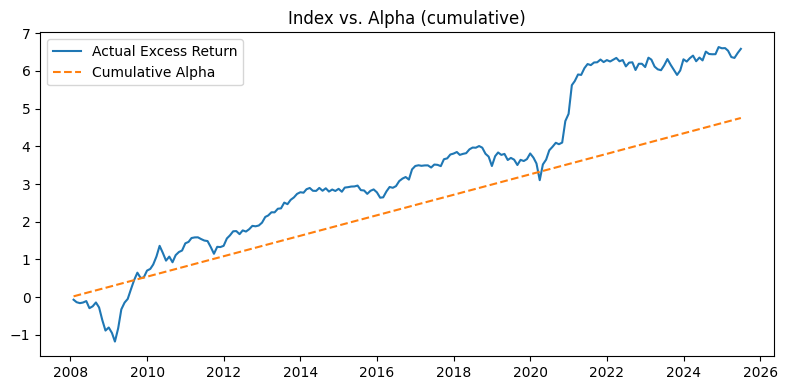

In [ ]:
cum_y_series   = pd.Series(np.cumsum(y), index=monthly.index)
cum_alpha_line = pd.Series(np.cumsum(np.full(len(y), alpha_unstd)), index=monthly.index)

fig_cum, ax_cum = plt.subplots(figsize=(8,4))
ax_cum.plot(cum_y_series, label="Actual Excess Return")
ax_cum.plot(cum_alpha_line, label="Cumulative Alpha", ls="--")
ax_cum.legend()
ax_cum.set_title("Index vs. Alpha (cumulative)")
plt.tight_layout()
plt.show()


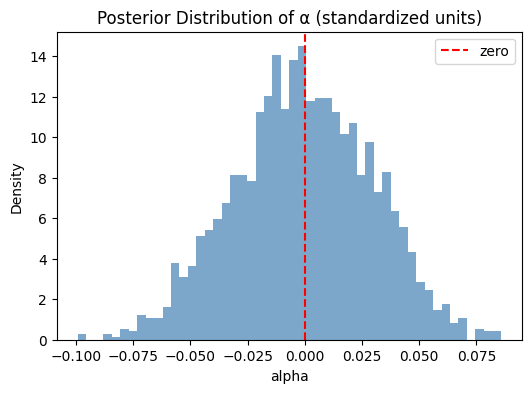

In [62]:
import matplotlib.pyplot as plt

# flatten all chains/draws into one array
alpha_samples = trace.posterior["alpha"].values.flatten()

plt.figure(figsize=(6,4))
plt.hist(alpha_samples, bins=50, density=True, alpha=0.7, color="steelblue")
plt.axvline(0, color="red", linestyle="--", label="zero")
plt.title("Posterior Distribution of α (standardized units)")
plt.xlabel("alpha")
plt.ylabel("Density")
plt.legend()
plt.show()


In [64]:
n, p = Xz.shape  # n observations, p predictors

with pm.Model() as tv_model:
    # Precision priors (use sigma instead of tau)
    sigma_alpha = pm.Exponential("sigma_alpha", 10.0)   # ~1/sqrt(Gamma)
    sigma_e     = pm.Exponential("sigma_e", 10.0)
    sigma_beta  = pm.Exponential("sigma_beta", 10.0, shape=p)
    
    # Random walk for alpha (length n)
    alpha = pm.GaussianRandomWalk("alpha", sigma=sigma_alpha, shape=n)
    
    # Random walks for each beta_j (shape n x p)
    betas = []
    for j in range(p):
        beta_j = pm.GaussianRandomWalk(f"beta_{j}", sigma=sigma_beta[j], shape=n)
        betas.append(beta_j)
    betas = pm.math.stack(betas, axis=1)  # shape (n, p)

    # Linear predictor
    mu = alpha + pm.math.sum(Xz * betas, axis=1)

    # Observation model
    y_like = pm.Normal("y_obs", mu=mu, sigma=sigma_e, observed=yz)

with tv_model:
    idata = pm.sample(
        draws=200,          # number of posterior draws per chain
        tune=100,           # warmup (adaptation) steps
        chains=4,           # run 4 parallel chains
        cores=4,            # use 4 CPU cores
        target_accept=0.9,  # keep this high to avoid divergences
        random_seed=42
    )

c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\creat\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\distributions\timeseries.py:290: UserWarning: Initial distribution not specified, defaultin

Output()

Sampling 4 chains for 100 tune and 200 draw iterations (400 + 800 draws total) took 16824 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


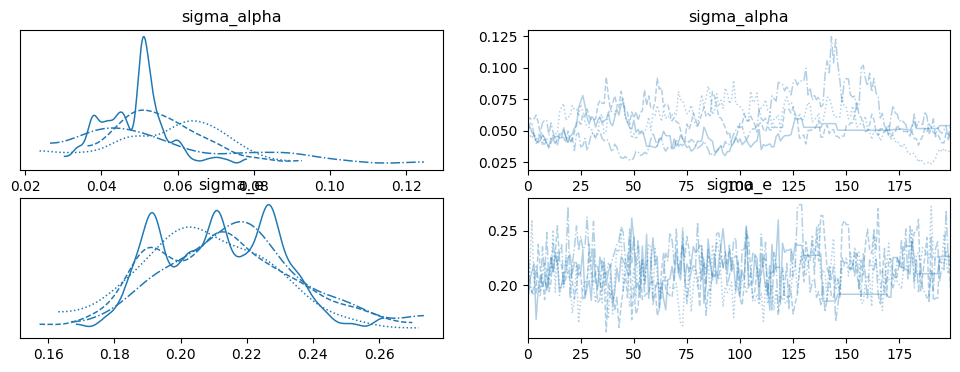

In [65]:
az.summary(idata, var_names=["sigma_alpha","sigma_e","sigma_beta"])
az.plot_trace(idata, var_names=["sigma_alpha","sigma_e"]);


C:\Users\creat\AppData\Local\Temp\ipykernel_18636\2197574496.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range("2015-01-31", periods=120, freq="M")


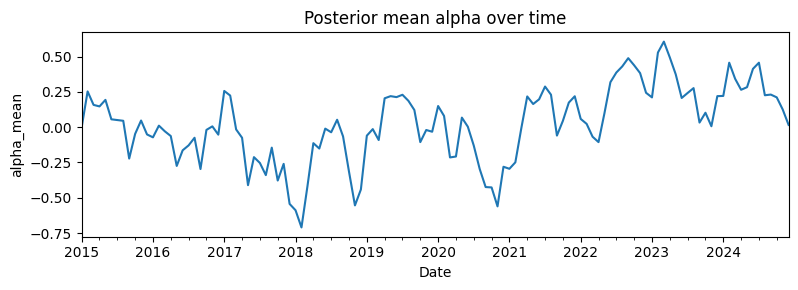

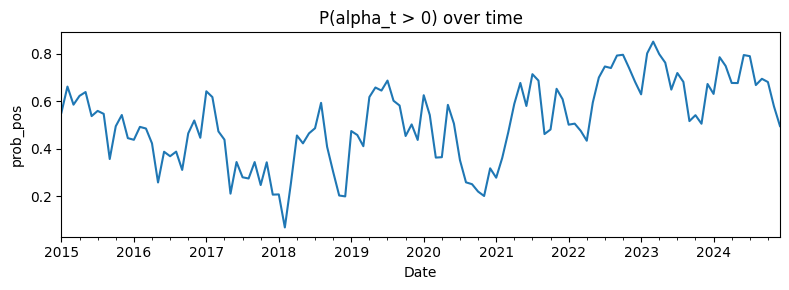

In [ ]:
# posterior samples: (chain, draw, time)
alpha_post = idata.posterior["alpha"]
alpha_mean_t = alpha_post.mean(("chain","draw")).values        # ᾱ_t  (time series)
alpha_prob_pos_t = (alpha_post > 0).mean(("chain","draw")).values  # P(α_t > 0) per time

# if you have a Date index for your data:
idx = pd.Index(dates_array, name="Date")   # same length as n
alpha_mean = pd.Series(alpha_mean_t, index=idx)
prob_pos   = pd.Series(alpha_prob_pos_t, index=idx)
alpha_mean.plot(title="Posterior mean alpha over time");
prob_pos.plot(title="P(alpha_t > 0) over time");  # “prob_pos vs index”


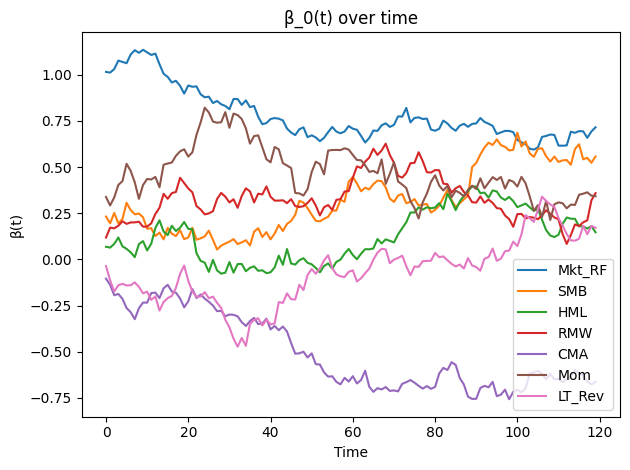

In [ ]:
# collect each beta_j(t) series
beta_means = {}
for j in range(p):
    b = idata.posterior[f"beta_{j}"]                         # (chain, draw, time)
    beta_means[j] = pd.Series(b.mean(("chain","draw")).values, index=idx)

# example: plot one factor at a time
beta_means[0].plot(title="β_0(t) over time");
# or all on one figure (careful with clutter)
ax = None
for j, s in beta_means.items():
    ax = s.plot(ax=ax, label=f"beta_{j}")
ax.legend(); ax.set_title("Time-varying betas");


In [ ]:
az.waic(idata)

Computed from 2000 posterior samples and 210 observations log-likelihood matrix.
         Estimate    SE
elpd_waic   -121.01   60.53
p_waic       29.98      -
waic        242.02   121.06


In [29]:
# === Start here AFTER your 'monthly' DataFrame is built ===
# monthly has columns like: ['SMALL HiBM', ..., 'Mkt-RF','SMB','HML','RMW','CMA','Mom','RF']

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# 1) Choose a target portfolio/ETF column and build excess returns y
port_col = 'SMALL HiBM'  # same as before, or any of the 25 portfolios
monthly = monthly.copy()
monthly['y'] = monthly[port_col] - monthly['RF']

# 2) Factor columns (match your actual names with the dash)
factors_cols = ['Mkt-RF','SMB','HML','RMW','CMA','Mom']

# 3) Build regimes (K-means) using market factor:
#    features: current market return (Mkt-RF), 3-month vol, 3-month momentum
mkt = monthly['Mkt-RF']
vol3 = mkt.rolling(3).std()
mom3 = mkt.rolling(3).sum()

reg_df = pd.concat([mkt, vol3, mom3], axis=1)
reg_df.columns = ['Mkt', 'vol3', 'mom3']
reg_df = reg_df.dropna()

# Align monthly to rows where regime features are available
monthly_reg = monthly.loc[reg_df.index].copy()

# KMeans (use fixed integer n_init for compatibility)
K = 4
kmeans = KMeans(n_clusters=K, random_state=13, n_init=10)
monthly_reg['regime'] = kmeans.fit_predict(reg_df[['Mkt','vol3','mom3']].values)

# 4) Prepare matrices (drop rows with any NaNs in y or factors)
keep_cols = ['y'] + factors_cols + ['regime']
monthly_reg = monthly_reg[keep_cols].dropna().copy()

y = monthly_reg['y'].to_numpy(dtype='float64')
X = monthly_reg[factors_cols].to_numpy(dtype='float64')
reg_idx = monthly_reg['regime'].to_numpy(dtype='int64')  # 0..K-1
n, p = X.shape

# 5) (Optional) z-score X and y to help samplers
X_mean, X_std = X.mean(0), X.std(0) + 1e-8
Xz = (X - X_mean) / X_std
y_mean, y_std = y.mean(), y.std() + 1e-8
yz = (y - y_mean) / y_std

print(f"Prepared matrices: n={n}, p={p}, regimes in {{0..{K-1}}}")
print("X columns:", factors_cols)
print("Regime counts:", pd.Series(reg_idx).value_counts().sort_index().to_dict())

Prepared matrices: n=208, p=6, regimes in {0..3}
X columns: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
Regime counts: {0: 98, 1: 62, 2: 9, 3: 39}


In [31]:
print(X_fct.dtypes)
print(reg_dum.dtypes)
print(X_reg.dtypes)
print(y_ser.dtype)

Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
Mom       float64
dtype: object
R_1    bool
R_2    bool
R_3    bool
dtype: object
Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
Mom       float64
R_1          bool
R_2          bool
R_3          bool
dtype: object
float64


C:\Users\creat\AppData\Local\Temp\ipykernel_18636\2545974975.py:109: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  upper = alpha_eff + 1.96*alpha_se.reindex_like(alpha_eff).fillna(method='ffill')
C:\Users\creat\AppData\Local\Temp\ipykernel_18636\2545974975.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lower = alpha_eff - 1.96*alpha_se.reindex_like(alpha_eff).fillna(method='ffill')


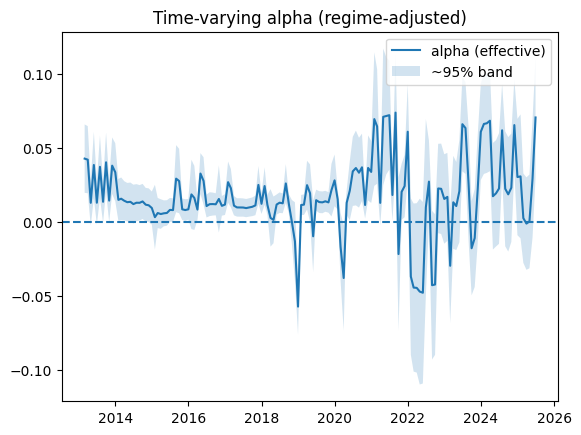

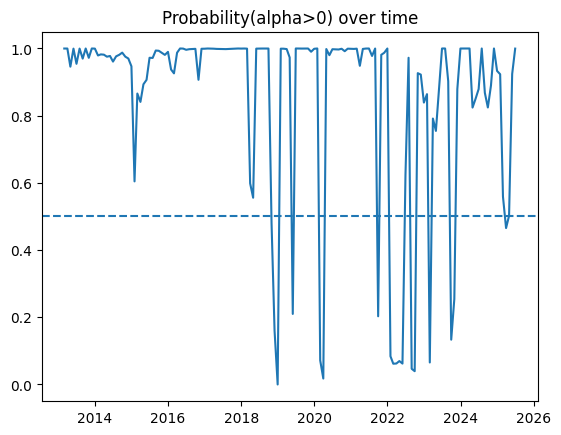

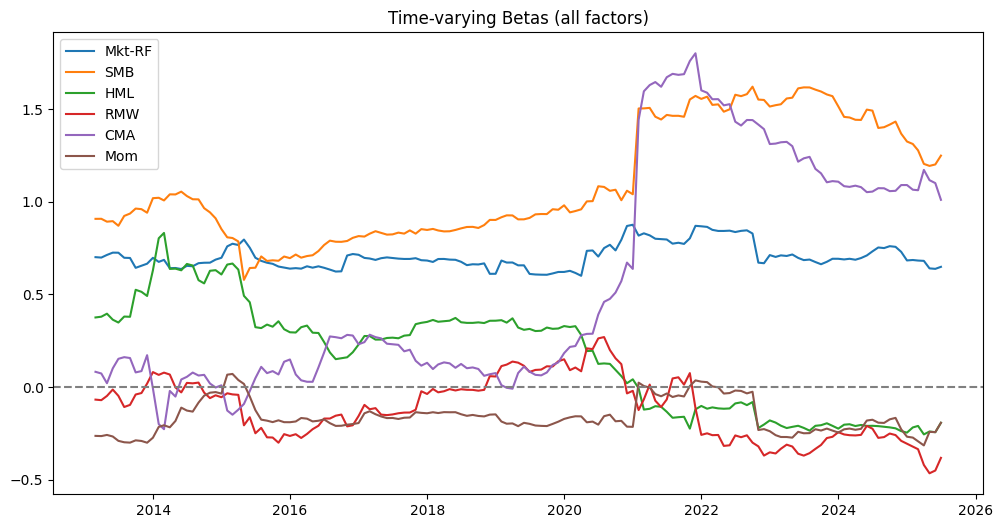

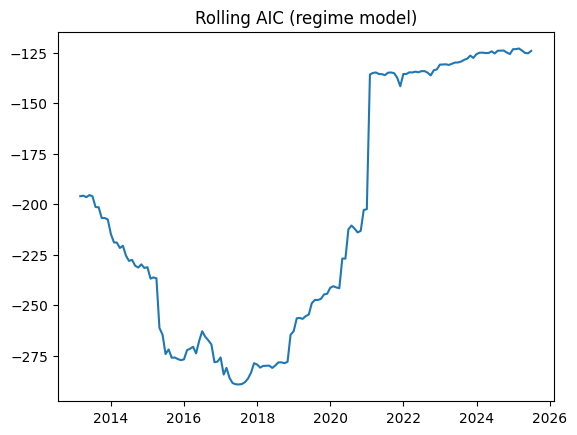

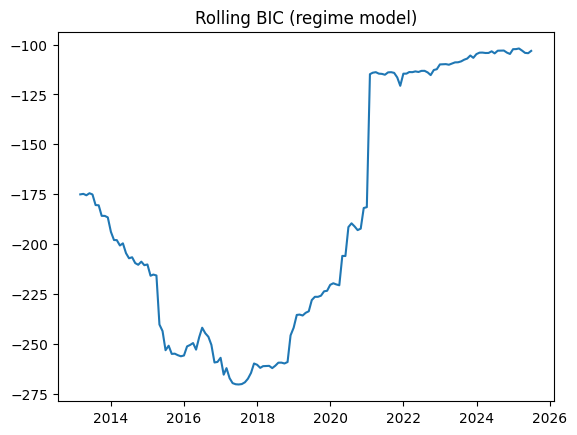

In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt

factors_cols = ['Mkt-RF','SMB','HML','RMW','CMA','Mom']

# ---------- helpers ----------
def clean_xy(X, y):
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask].astype('float64')
    y = y.loc[mask].astype('float64')
    finite = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y.to_numpy())
    return X.loc[finite], y.loc[finite]

def rolling_ols_alpha_regimes(monthly_reg, window=60, hac_lags=3):
    y = pd.to_numeric(monthly_reg['y'], errors='coerce')
    X_f = monthly_reg[factors_cols].apply(pd.to_numeric, errors='coerce')
    reg = monthly_reg['regime']

    # K-1 regime dummies (omit base to avoid collinearity)
    reg_dum = pd.get_dummies(reg, prefix='R', drop_first=True)
    X_full = pd.concat([X_f, reg_dum], axis=1)

    X, y = clean_xy(X_full, y)
    reg = reg.loc[X.index]

    idx = y.index
    # storage
    alpha_eff  = pd.Series(index=idx, dtype=float)
    alpha_se   = pd.Series(index=idx, dtype=float)
    prob_pos   = pd.Series(index=idx, dtype=float)
    aic_ser    = pd.Series(index=idx, dtype=float)
    bic_ser    = pd.Series(index=idx, dtype=float)
    betas = pd.DataFrame(index=idx, columns=factors_cols, dtype=float)
    thetas = pd.DataFrame(index=idx, columns=[c for c in X.columns if c.startswith('R_')], dtype=float)

    for t in range(window-1, len(idx)):
        sl = slice(t-(window-1), t+1)
        Xw = sm.add_constant(X.iloc[sl], has_constant='add')
        yw = y.iloc[sl]

        # fit with HAC s.e.
        res = sm.OLS(yw, Xw).fit(cov_type='HAC', cov_kwds={'maxlags': hac_lags})

        # params & cov for this window
        params = res.params
        cov    = res.cov_params()

        # which regime is active at date t?
        active_reg = reg.iloc[t]
        # name of the dummy that corresponds to this regime (if not base)
        active_dummy = f'R_{active_reg}'
        # if that dummy isn't in the columns, it means it's the base (omitted) regime
        v = pd.Series(0.0, index=params.index)
        v['const'] = 1.0
        if active_dummy in params.index:
            v[active_dummy] = 1.0

        # effective alpha = const + active theta
        a_hat = float((v * params).sum())
        var_a = float(v @ cov.to_numpy() @ v.to_numpy())   # v' Cov v
        se_a  = np.sqrt(max(var_a, 0.0))

        alpha_eff.iloc[t] = a_hat
        alpha_se.iloc[t]  = se_a
        prob_pos.iloc[t]  = 1.0 - norm.cdf(0.0, loc=a_hat, scale=se_a) if se_a > 0 else (1.0 if a_hat>0 else 0.0)

        # store time-varying factor betas (only factor columns)
        for c in factors_cols:
            if c in params:
                betas.loc[idx[t], c] = params[c]
        # store theta dummies for reference
        for c in thetas.columns:
            if c in params:
                thetas.loc[idx[t], c] = params[c]

        aic_ser.iloc[t] = res.aic
        bic_ser.iloc[t] = res.bic

    out = {
        'alpha_eff': alpha_eff.dropna(),
        'alpha_se':  alpha_se.dropna(),
        'prob_pos':  prob_pos.dropna(),
        'betas':     betas.dropna(how='all'),
        'thetas':    thetas.dropna(how='all'),
        'aic':       aic_ser.dropna(),
        'bic':       bic_ser.dropna(),
        'designX':   X,        # for debugging
        'reg_dummies_cols': [c for c in X.columns if c.startswith('R_')]
    }
    return out

# ---------- run ----------
roll = rolling_ols_alpha_regimes(monthly_reg, window=60, hac_lags=3)

alpha_eff = roll['alpha_eff']
alpha_se  = roll['alpha_se']
prob_pos  = roll['prob_pos']
betas_t   = roll['betas']
aic_t     = roll['aic']
bic_t     = roll['bic']

# ---------- plots ----------
# (1) alpha_t with ±1.96*SE band
plt.figure()
plt.plot(alpha_eff.index, alpha_eff.values, label='alpha (effective)')
upper = alpha_eff + 1.96*alpha_se.reindex_like(alpha_eff).fillna(method='ffill')
lower = alpha_eff - 1.96*alpha_se.reindex_like(alpha_eff).fillna(method='ffill')
plt.fill_between(alpha_eff.index, lower, upper, alpha=0.2, label='~95% band')
plt.axhline(0, linestyle='--')
plt.title('Time-varying alpha (regime-adjusted)')
plt.legend()
plt.show()

# (2) Pr(alpha>0)
plt.figure()
plt.plot(prob_pos.index, prob_pos.values)
plt.axhline(0.5, linestyle='--')
plt.title('Probability(alpha>0) over time')
plt.show()

# (3) Time-varying betas (all factors)
plt.figure(figsize=(12,6))

for c in factors_cols:
    if c in betas_t.columns:
        s = betas_t[c].dropna()
        if len(s):
            plt.plot(s.index, s.values, label=f'{c}')

plt.axhline(0, linestyle='--', color='gray')
plt.title("Time-varying Betas (all factors)")
plt.legend()
plt.show()

# (4) Rolling AIC/BIC (use for model comparison instead of WAIC in OLS)
plt.figure()
plt.plot(aic_t.index, aic_t.values)
plt.title('Rolling AIC (regime model)')
plt.show()

plt.figure()
plt.plot(bic_t.index, bic_t.values)
plt.title('Rolling BIC (regime model)')
plt.show()


Global AIC: -206.54
Global BIC: -185.97


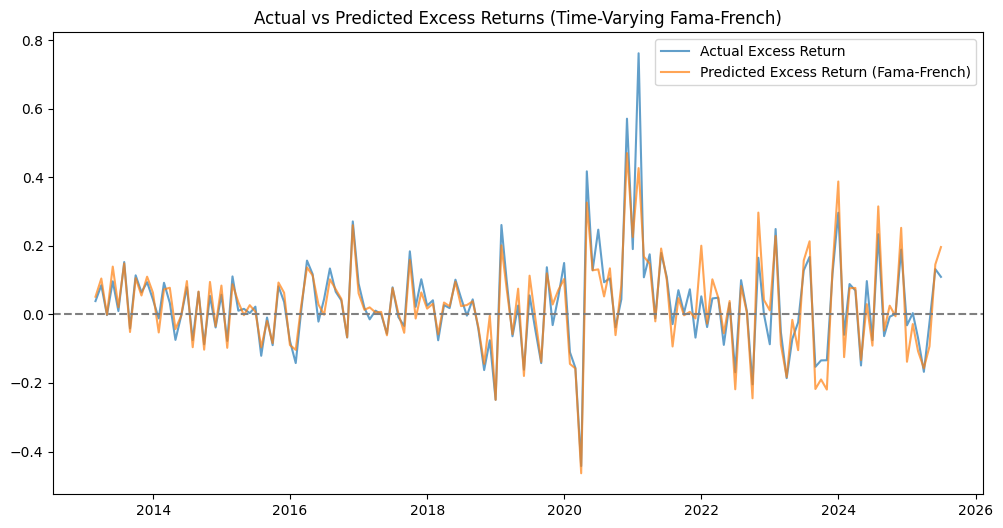

In [40]:
aic_global = aic_t.mean()
bic_global = bic_t.mean()
print(f'Global AIC: {aic_global:.2f}')
print(f'Global BIC: {bic_global:.2f}')

# actual excess return
actual_excess = monthly_reg.loc[roll['betas'].index, 'y']

# predicted = alpha_eff + betas @ factors
predicted = roll['alpha_eff'].copy()
for c in factors_cols:
    if c in roll['betas']:
        predicted += roll['betas'][c] * monthly_reg.loc[predicted.index, c]

# Plot comparison
plt.figure(figsize=(12,6))
plt.plot(actual_excess.index, actual_excess, label="Actual Excess Return", alpha=0.7)
plt.plot(predicted.index, predicted, label="Predicted Excess Return (Fama-French)", alpha=0.7)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Actual vs Predicted Excess Returns (Time-Varying Fama-French)")
plt.legend()
plt.show()